In [3]:
import shutil

# Kreiraj direktorij ako ne postoji
!mkdir -p ~/.kaggle

# Premjesti kaggle.json u ~/.kaggle/
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

# Postavi odgovarajuće dozvole
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p /content/data --unzip


Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.73G/2.74G [00:20<00:00, 163MB/s]
100% 2.74G/2.74G [00:20<00:00, 143MB/s]


In [ ]:
!kaggle datasets list


ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
abdulmalik1518/mobiles-dataset-2025                              Mobiles Dataset (2025)                            20KB  2025-02-18 06:50:24           6231        107  1.0              
asinow/car-price-dataset                                         Car Price Dataset                                135KB  2025-01-26 19:53:28          23027        370  1.0              
mahmoudelhemaly/students-grading-dataset                         Student Performance & Behavior Dataset           508KB  2025-02-17 17:38:46           5010         98  1.0              
samikshadalvi/lungs-diseases-dataset                             Lungs

In [7]:
import os

dataset_path = "/content/data"  # Postavi točnu putanju do dataseta
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for file in files[:5]:  # Prikaz prvih 5 datoteka po direktoriju
        print(f"  {file}")


/content/data
  class_dict.csv
  metadata.csv
/content/data/train
  412210_mask.png
  784518_sat.jpg
  889920_mask.png
  639149_sat.jpg
  941237_sat.jpg
/content/data/test
  103742_sat.jpg
  565696_sat.jpg
  979233_sat.jpg
  22767_sat.jpg
  112946_sat.jpg
/content/data/valid
  998699_sat.jpg
  637614_sat.jpg
  411176_sat.jpg
  550979_sat.jpg
  386993_sat.jpg


In [8]:
import pandas as pd

# Učitaj class_dict.csv
class_dict_path = "/content/data/class_dict.csv"
class_dict = pd.read_csv(class_dict_path)

# Prikaži prvih nekoliko redaka
print(class_dict.head())


               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255


HSV SEGMENTACIJA

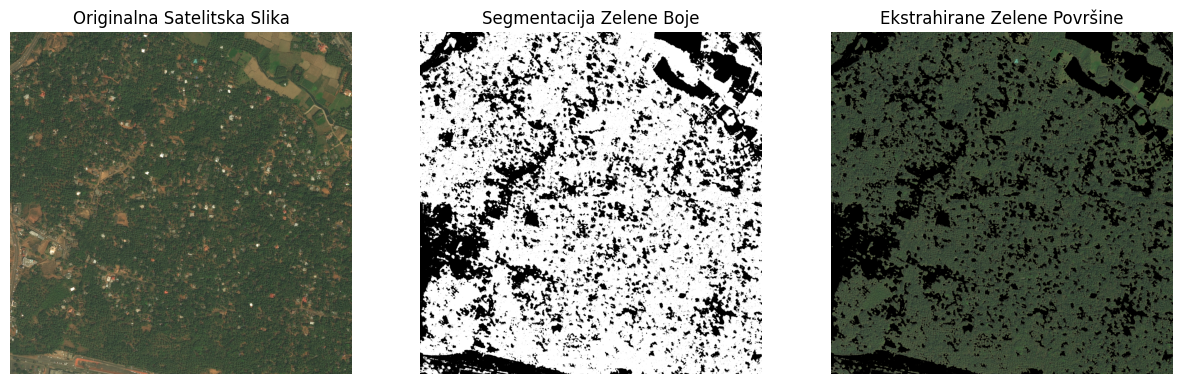

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_green_areas(image_path):
    """Segmentira zelene površine iz satelitske slike koristeći HSV pragiranje."""
    # Učitaj sliku
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Konverzija u HSV prostor
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Definiraj pragove za zelenu boju
    lower_green = np.array([35, 40, 40])   # Donja granica (Hue, Saturation, Value)
    upper_green = np.array([85, 255, 255]) # Gornja granica

    # Kreiraj masku
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Primijeni masku na originalnu sliku
    result = cv2.bitwise_and(image, image, mask=mask)

    # Prikaži rezultate
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Originalna Satelitska Slika")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Segmentacija Zelene Boje")
    ax[1].axis("off")

    ax[2].imshow(result)
    ax[2].set_title("Ekstrahirane Zelene Površine")
    ax[2].axis("off")

    plt.show()

    return mask

# Testiraj funkciju
image_path = "/content/data/train/119079_sat.jpg"
segmented_mask = segment_green_areas(image_path)


**MASKA MASKA MASKA**

RGB vrijednosti zelenih površina: [(255, 255, 0), (255, 0, 255), (0, 255, 0)]


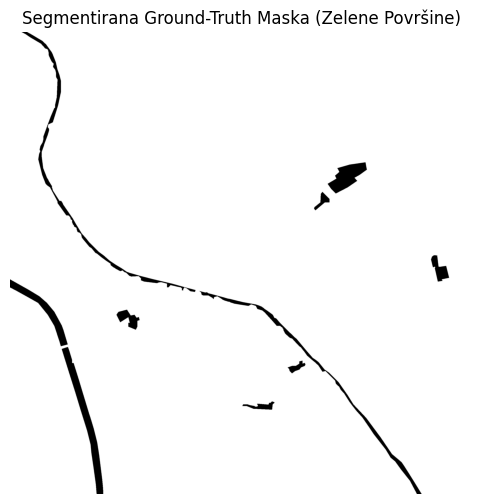

In [52]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Učitaj definicije klasa iz class_dict.csv
class_dict_path = "/content/data/class_dict.csv"
class_dict = pd.read_csv(class_dict_path)

# Zelene klase prema tvojoj definiciji
green_classes = class_dict[class_dict["name"].isin(["agriculture_land", "rangeland", "forest_land"])]

# Pretvori boje u tuple liste
GREEN_CLASSES = [(r, g, b) for r, g, b in zip(green_classes["r"], green_classes["g"], green_classes["b"])]
print("RGB vrijednosti zelenih površina:", GREEN_CLASSES)

def load_and_segment_mask(mask_path):
    """Učitava ground-truth masku i izdvaja zelene površine."""
    mask = cv2.imread(mask_path)  # Učitaj kao RGB
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Konverzija iz OpenCV BGR u RGB

    # Kreiraj binarnu masku za zelene površine
    binary_mask = np.zeros(mask.shape[:2], dtype=np.uint8)

    for green in GREEN_CLASSES:
        green_mask = np.all(mask == green, axis=-1)
        binary_mask[green_mask] = 1  # Obeleži kao zelenu površinu

    return binary_mask

# Učitaj i segmentiraj masku
mask_path = "/content/data/train/119_mask.png"
ground_truth_mask = load_and_segment_mask(mask_path)

# Prikaz rezultata
plt.figure(figsize=(6, 6))
plt.imshow(ground_truth_mask, cmap="gray")
plt.title("Segmentirana Ground-Truth Maska (Zelene Površine)")
plt.axis("off")
plt.show()


IoU (Intersection over Union) score: 0.7049


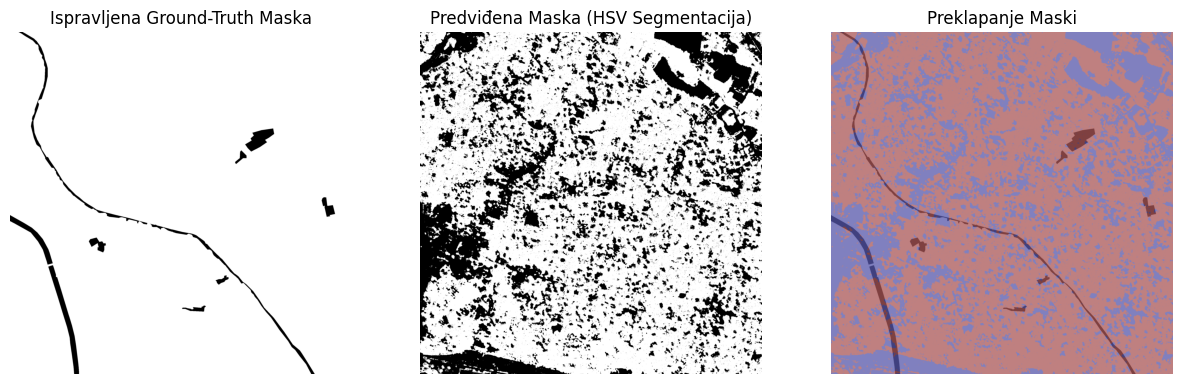

In [53]:
def evaluate_segmentation(predicted_mask, ground_truth_mask):
    """Računa IoU za evaluaciju segmentacije."""
    predicted_mask = (predicted_mask > 0).astype(np.uint8)  # Binarizacija
    ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0

    print(f"IoU (Intersection over Union) score: {iou:.4f}")

    # Prikaz rezultata
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(ground_truth_mask, cmap="gray")
    ax[0].set_title("Ispravljena Ground-Truth Maska")
    ax[0].axis("off")

    ax[1].imshow(predicted_mask, cmap="gray")
    ax[1].set_title("Predviđena Maska (HSV Segmentacija)")
    ax[1].axis("off")

    ax[2].imshow(ground_truth_mask, cmap="gray", alpha=0.5)
    ax[2].imshow(predicted_mask, cmap="jet", alpha=0.5)
    ax[2].set_title("Preklapanje Maski")
    ax[2].axis("off")

    plt.show()

# Evaluacija
evaluate_segmentation(segmented_mask, ground_truth_mask)


K MEANS SEGMENTACIJA

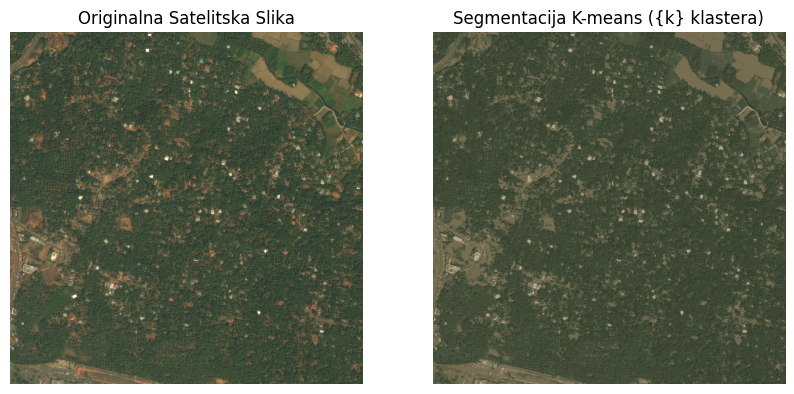

In [37]:
from sklearn.cluster import KMeans

def kmeans_segmentation(image_path, k=5):
    """Segmentira sliku pomoću K-means klasteriranja."""
    # Učitaj sliku
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pretvori sliku u 2D niz (pikseli kao vektori)
    pixels = image.reshape((-1, 3))

    # Primijeni K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)

    # Rekonstruiraj sliku iz klastera
    segmented_image = kmeans.cluster_centers_.astype("uint8")[labels]
    segmented_image = segmented_image.reshape(image.shape)

    # Prikaži rezultate
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Originalna Satelitska Slika")
    ax[0].axis("off")

    ax[1].imshow(segmented_image)
    ax[1].set_title("Segmentacija K-means ({k} klastera)")
    ax[1].axis("off")

    plt.show()

    return segmented_image, labels.reshape(image.shape[:2])

# Testiraj K-means segmentaciju
image_path = "/content/data/train/119079_sat.jpg"
segmented_image, kmeans_mask = kmeans_segmentation(image_path, k=4)


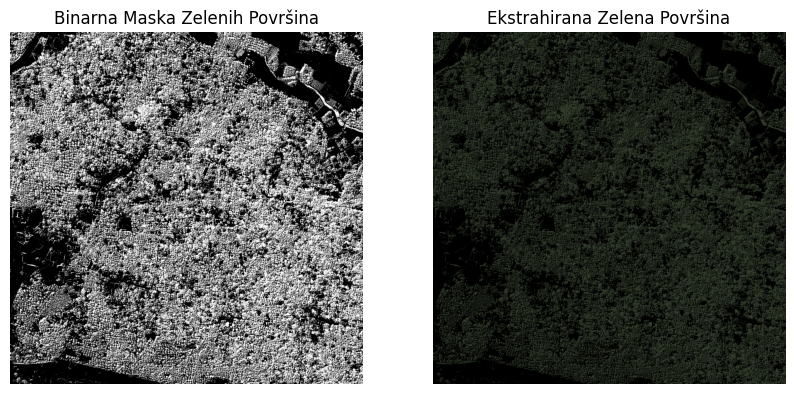

In [38]:
def extract_green_cluster(kmeans_labels, image, cluster_idx):
    """Ekstrahira određeni klaster iz segmentacije K-means."""
    # Kreiraj binarnu masku
    green_mask = (kmeans_labels == cluster_idx).astype(np.uint8)

    # Primijeni masku na originalnu sliku
    green_segment = cv2.bitwise_and(image, image, mask=green_mask)

    # Prikaži rezultate
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(green_mask, cmap="gray")
    ax[0].set_title("Binarna Maska Zelenih Površina")
    ax[0].axis("off")

    ax[1].imshow(green_segment)
    ax[1].set_title("Ekstrahirana Zelena Površina")
    ax[1].axis("off")

    plt.show()

    return green_mask

# Odaberi klaster koji najviše odgovara zelenim površinama
green_mask = extract_green_cluster(kmeans_mask, segmented_image, cluster_idx=1)  # Možda treba promijeniti index


IoU (Intersection over Union) score: 0.4354


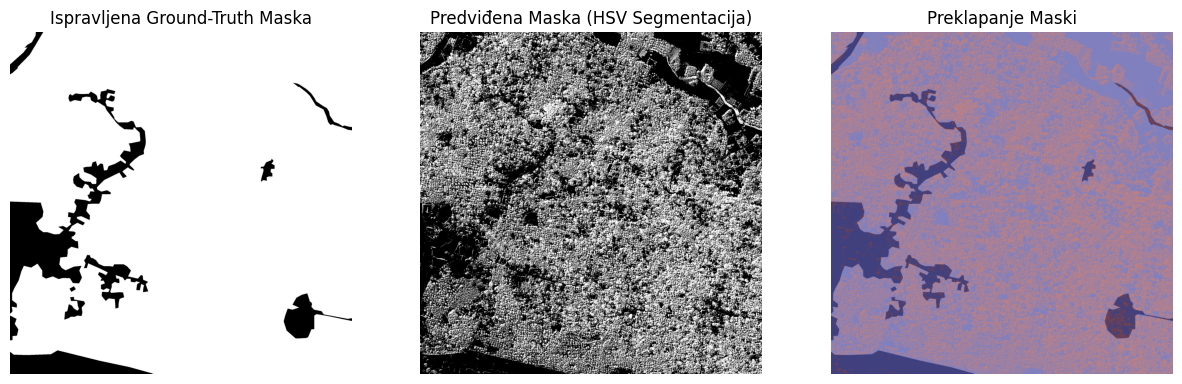

In [39]:
evaluate_segmentation(green_mask, ground_truth_mask)


KOMBINACIJA HSV I K MEANS

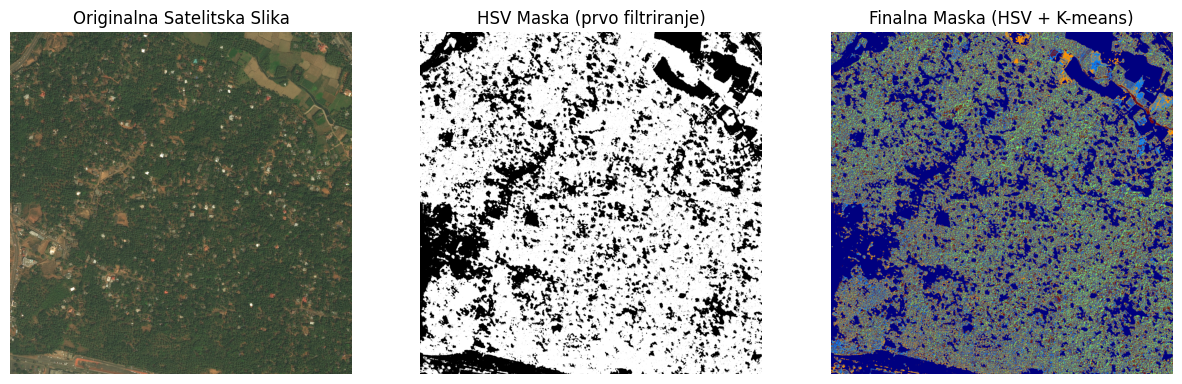

In [40]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hsv_segmentation(image):
    """Segmentira potencijalne zelene površine pomoću HSV pragiranja."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Definiraj pragove za zelenu boju
    lower_green = np.array([35, 40, 40])   # Donja granica (Hue, Saturation, Value)
    upper_green = np.array([85, 255, 255]) # Gornja granica

    # Kreiraj masku
    mask = cv2.inRange(hsv, lower_green, upper_green)

    return mask

def kmeans_segmentation(image, mask, k=3):
    """Koristi K-means klasteriranje unutar HSV segmentiranih područja."""
    # Maskiraj sliku tako da ostavi samo regije prepoznate u HSV
    image_masked = cv2.bitwise_and(image, image, mask=mask)

    # Pripremi podatke za K-means
    pixels = image_masked.reshape((-1, 3))
    valid_pixels = pixels[mask.flatten() > 0]  # Samo piksle iz HSV segmentacije

    # Ako nema dovoljno piksela, vrati originalni HSV rezultat
    if valid_pixels.shape[0] == 0:
        return mask

    # K-means klasteriranje
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(valid_pixels)

    # Rekonstruiraj masku
    clustered_mask = np.zeros(mask.shape, dtype=np.uint8)
    clustered_mask[mask > 0] = labels + 1  # Oznake klastera (1, 2, ...)

    return clustered_mask

def combine_hsv_kmeans(image_path, k=3):
    """Kombinira HSV segmentaciju i K-means klasteriranje."""
    # Učitaj sliku
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Korak 1: HSV segmentacija
    hsv_mask = hsv_segmentation(image)

    # Korak 2: K-means segmentacija na HSV filtriranim pikselima
    kmeans_mask = kmeans_segmentation(image, hsv_mask, k)

    # Prikaži rezultate
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Originalna Satelitska Slika")
    ax[0].axis("off")

    ax[1].imshow(hsv_mask, cmap="gray")
    ax[1].set_title("HSV Maska (prvo filtriranje)")
    ax[1].axis("off")

    ax[2].imshow(kmeans_mask, cmap="jet")
    ax[2].set_title("Finalna Maska (HSV + K-means)")
    ax[2].axis("off")

    plt.show()

    return kmeans_mask

# Testiranje kombinacije
image_path = "/content/data/train/119079_sat.jpg"
final_mask = combine_hsv_kmeans(image_path, k=4)


IoU (Intersection over Union) score: 0.7549


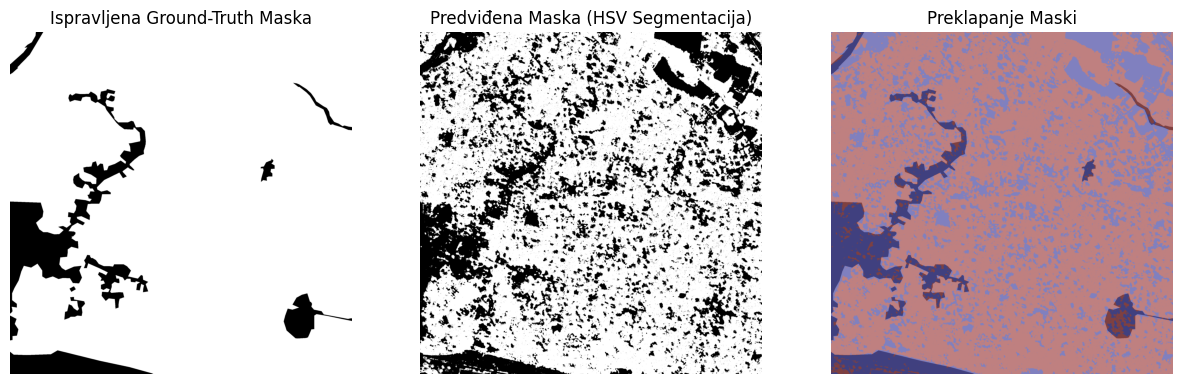

In [41]:
# Učitaj ground-truth masku
ground_truth_mask = load_and_segment_mask("/content/data/train/119079_mask.png")

# Evaluacija segmentacije
evaluate_segmentation(final_mask, ground_truth_mask)


In [42]:
import cv2
import numpy as np
import os

# Odaberi primjer multispektralne slike
image_path = "/content/data/train/10233_sat.jpg"

# Učitaj sliku
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Učitavanje bez konverzije
print(f"Dimenzije slike: {image.shape}")

# Ako ima 4 ili više kanala → postoji NIR
if image.shape[-1] >= 4:
    print("✅ Dataset sadrži NIR kanal!")
else:
    print("❌ Dataset nema NIR kanal (samo RGB).")


Dimenzije slike: (2448, 2448, 3)
❌ Dataset nema NIR kanal (samo RGB).


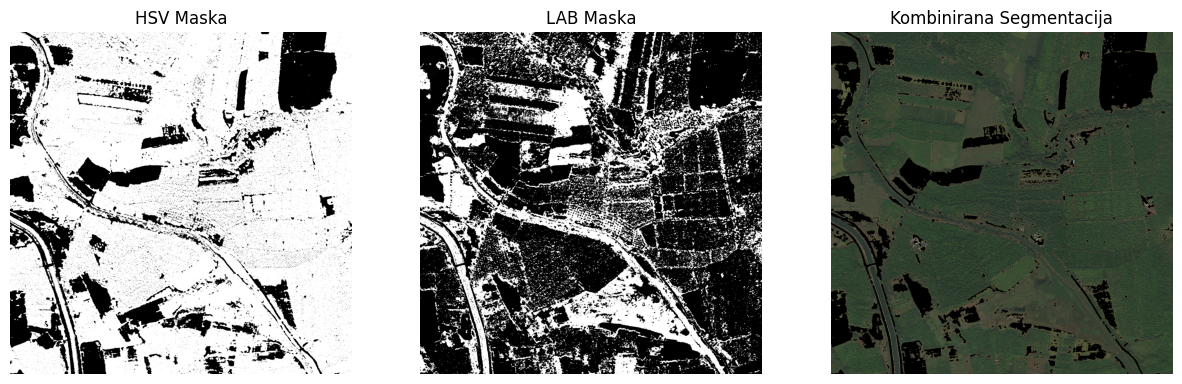

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adaptive_color_segmentation(image_path):
    """Segmentira zelene površine koristeći adaptivno pragiranje u HSV i LAB prostoru."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Konverzija u HSV i LAB prostore
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # HSV pragiranje (zelena boja)
    lower_hsv = np.array([30, 40, 40])  # Hue, Saturation, Value
    upper_hsv = np.array([90, 255, 255])
    mask_hsv = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # LAB pragiranje (zeleni tonovi)
    lower_lab = np.array([20, 120, 20])  # L, A, B
    upper_lab = np.array([255, 160, 140])
    mask_lab = cv2.inRange(lab, lower_lab, upper_lab)

    # Kombinacija maski
    combined_mask = cv2.bitwise_or(mask_hsv, mask_lab)

    # Primjena na originalnu sliku
    result = cv2.bitwise_and(image, image, mask=combined_mask)

    # Prikaz
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(mask_hsv, cmap="gray")
    ax[0].set_title("HSV Maska")
    ax[0].axis("off")

    ax[1].imshow(mask_lab, cmap="gray")
    ax[1].set_title("LAB Maska")
    ax[1].axis("off")

    ax[2].imshow(result)
    ax[2].set_title("Kombinirana Segmentacija")
    ax[2].axis("off")

    plt.show()

    return combined_mask

# Testiranje metode
image_path = "/content/data/train/119_sat.jpg"
adaptive_mask = adaptive_color_segmentation(image_path)


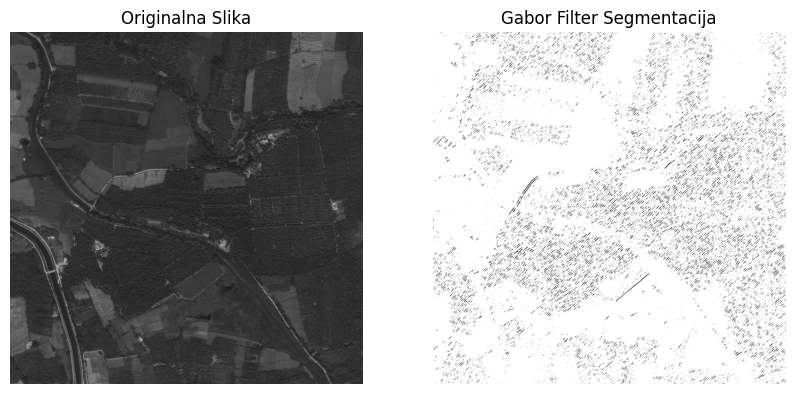

In [55]:
def apply_gabor_filter(image_path):
    """Koristi Gabor filter za izdvajanje tekstura u slici."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Radimo u grayscale
    g_kernel = cv2.getGaborKernel((21, 21), 5, np.pi/4, 10, 0.5, 0, ktype=cv2.CV_32F)

    filtered = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Originalna Slika")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap="gray")
    plt.title("Gabor Filter Segmentacija")
    plt.axis("off")

    plt.show()

    return filtered

# Testiranje metode
gabor_mask = apply_gabor_filter(image_path)


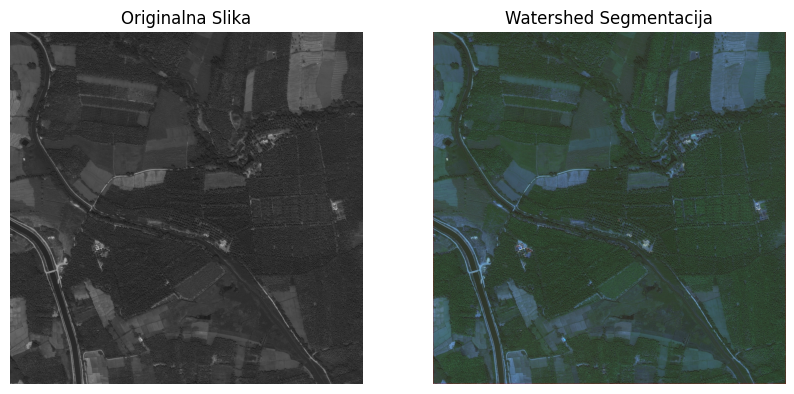

In [56]:
def watershed_segmentation(image_path):
    """Koristi Watershed algoritam za segmentaciju vegetacije."""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Pronađi rubove pomoću Canny detekcije
    edges = cv2.Canny(gray, 50, 150)

    # Konstruiraj marker pomoću morfološke obrade
    kernel = np.ones((3,3), np.uint8)
    sure_bg = cv2.dilate(edges, kernel, iterations=2)

    # Watershed segmentacija
    _, markers = cv2.connectedComponents(sure_bg)
    markers = markers + 1
    markers[edges == 255] = 0

    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    image_copy[markers == -1] = [255, 0, 0]  # Oboji rubove

    # Prikaži rezultate
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Originalna Slika")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_copy)
    plt.title("Watershed Segmentacija")
    plt.axis("off")

    plt.show()

    return markers

# Testiranje Watershed metode
watershed_result = watershed_segmentation(image_path)


In [47]:
print(f"Adaptive mask shape: {adaptive_mask.shape}")
print(f"Gabor mask shape: {gabor_mask.shape}")
print(f"Watershed result shape: {watershed_result.shape}")


Adaptive mask shape: (2448, 2448)
Gabor mask shape: (2448, 2448)
Watershed result shape: (2448, 2448)


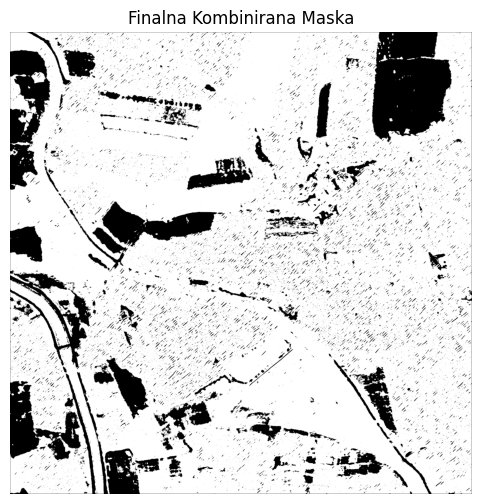

In [57]:
# Osiguraj da su sve maske uint8 (0 i 255)
adaptive_mask = (adaptive_mask > 0).astype(np.uint8) * 255
gabor_mask = (gabor_mask > 0).astype(np.uint8) * 255
watershed_result = (watershed_result > 0).astype(np.uint8) * 255

# Kombinacija maski nakon konverzije
combined_mask = cv2.bitwise_and(adaptive_mask, gabor_mask)
combined_mask = cv2.bitwise_and(combined_mask, watershed_result)

# Prikaži finalnu masku
plt.figure(figsize=(6, 6))
plt.imshow(combined_mask, cmap="gray")
plt.title("Finalna Kombinirana Maska")
plt.axis("off")
plt.show()


✅ IoU (Intersection over Union) score: 0.8142


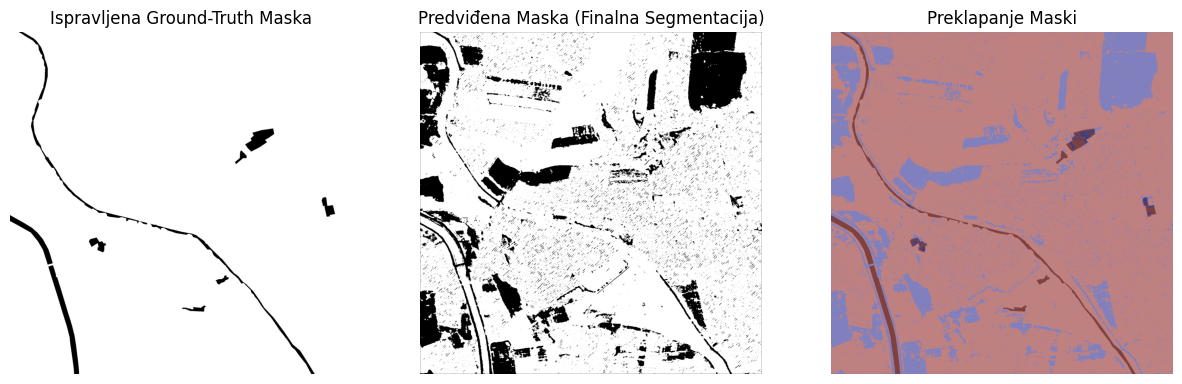

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_segmentation(predicted_mask, ground_truth_mask):
    """Računa IoU score i prikazuje preklapanje maski."""

    # Osiguraj da su obje maske binarne (0 i 1)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)
    ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

    # Izračunaj Intersection over Union (IoU)
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0

    print(f"✅ IoU (Intersection over Union) score: {iou:.4f}")

    # Prikaži maske i preklapanje
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(ground_truth_mask, cmap="gray")
    ax[0].set_title("Ispravljena Ground-Truth Maska")
    ax[0].axis("off")

    ax[1].imshow(predicted_mask, cmap="gray")
    ax[1].set_title("Predviđena Maska (Finalna Segmentacija)")
    ax[1].axis("off")

    ax[2].imshow(ground_truth_mask, cmap="gray", alpha=0.5)
    ax[2].imshow(predicted_mask, cmap="jet", alpha=0.5)
    ax[2].set_title("Preklapanje Maski")
    ax[2].axis("off")

    plt.show()

    return iou

# ✅ Primjena evaluacije na finalnu masku
ground_truth_mask = load_and_segment_mask("/content/data/train/119_mask.png")  # Učitaj ground-truth
iou_score = evaluate_segmentation(combined_mask, ground_truth_mask)
